# Liveness-Tracking Results

Here are the results for the liveness tests.

## 1. Imports

Import the libraries to process the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from math import prod
import os

## 2. Read Data

Read in the data for each test result.

In [2]:
# The data is stored in a 5XX.csv for the serial tests, and 6XX.csv for the parallel tests
# The data files are in the `/data` folder

# Check if the data is loaded
# If not, load it
if 'all_data' in locals():
    print("Data already loaded")
else:
    # A structure for storing the data
    all_data = {}

    for i in range(500, 600):
        if os.path.isfile("data/page-liveness-test/" + str(i) + ".csv"):
            all_data[i] = pd.read_csv("data/page-liveness-test/" + str(i) + ".csv")
            print("Loaded data for test " + str(i))

Loaded data for test 500


In [3]:
class Page:
    def __init__(self, physical_address, site):
        self.physical_address = physical_address
        self.site = site
        self.data = []
    
    def __hash__(self):
        return hash(self.physical_address)

    def get_address(self):
        return self.physical_address

    def get_site(self):
        return self.site
    
    def get_age(self, interval):
        return interval - self.get_first_interval()

    def add_row(self, row):
        self.data.append(row)

    def get_data(self):
        return self.data
    
    def get_interval_of_last_write(self, interval = None):
        '''
        Get the interval number of the last write to this page

        If the page was never written to, this will return -1
        '''
        if interval is not None:
            for row in self.data[::-1]:
                if row["Interval #"] <= interval and row["Written During This Interval?"]:
                    return row["Interval #"]
            return -1

        for row in self.data[::-1]:
            if row["Written During This Interval?"]:
                return row["Interval #"]
        return -1
    
    def get_first_interval(self):
        '''
        Get the first interval this page was alive for
        '''
        return self.data[0]["Interval #"]
    
    def get_last_interval(self):
        return self.data[-1]["Interval #"]
    
    def get_data_after_last_write(self):
        '''
        Get the data after the last write to this page

        If the page was never written to, this will return the entire data
        '''
        result = []
        for row in self.data:
            if row["Written During This Interval?"]:
                result = []
            else:
                result.append(row)
        assert sum([1 for row in result if row["Written During This Interval?"]]) == 0
        last_write = self.get_interval_of_last_write()
        assert len(result) == 0 or result[0]["Interval #"] == last_write + 1 or last_write == -1
        return result

    def get_data_for_longest_lifetime_without_write(self):
        '''
        Get the data for the longest lifetime without a write to this page

        If this page was always written to, this will return an empty list
        '''

        longest_contiguous = 0
        current_contiguous = 0

        result = []
        for i, row in enumerate(self.data):
            if not row["Written During This Interval?"]:
                current_contiguous += 1
            else:
                if current_contiguous > longest_contiguous:
                    result = self.data[i-current_contiguous:i]
                    longest_contiguous = current_contiguous

                current_contiguous = 0

        if current_contiguous > longest_contiguous:
            result = self.data[-current_contiguous:]
            longest_contiguous = current_contiguous


        assert len(result) == self.get_longest_lifetime_without_write()
        assert len(result) == longest_contiguous
        assert sum([1 for row in result if row["Written During This Interval?"]]) == 0

        return result
    
    def was_written_to_during_interval(self, interval):
        '''
        Check if this page was written to during the given interval
        '''
        return any([row["Interval #"] == interval and row["Written During This Interval?"] for row in self.data])

    def get_average_compression_savings_in_bytes(self):
        '''
        Get the average amount of memory saved by compressing the physical pages in bytes
        '''
        return sum([row["Page Physical Page Compression Savings (bytes)"] for row in self.data]) / len(self.data)

    def __repr__(self):
        return "Page: " + str(self.physical_address) + " at " + str(self.site)

# class Address:
#     def __init__(self, address, site):
#         self.address = address
#         self.site = site
#         self.associated_objects = []

#     def get_objects(self):
#         return self.associated_objects

#     def add_row(self, row):
#         if row["Is new?"]:
#             self.associated_objects.append(Object(self))
#         self.associated_objects[-1].add_row(row) 

#     def __str__(self):
#         result = "Address: " + str(self.address) + "\n"
#         for obj in self.associated_objects:
#             result += str(obj) + "\n"
#         return result

#     def __repr__(self):
#         return str(self)

## 3. Process Results

Go through the data and process some results.

## 3.1 New, Stale, and Hot Allocations

This graphs the number of live objects each iteration, the number of new objects allocated that iteration, and the objects that were written to that iteration. The ages of the objects are also denoted by the color, and the brightness indicates the compression savings.

### 3.1.1 Divide the data into information about each object

In [4]:
if 'tests' in locals() and 'test_page_data' in locals():
    print("Tests already loaded")
else:
    # Get the tests from the data
    tests = list(all_data.keys())
    # Get the number of tests
    print("Number of tests: " + str(len(tests)))

    test_page_data = {}

    # Iterate over the tests and graph the results
    for test in tests:
        # Get the data for the test
        test_data = all_data[test]

        # For each test interval, make the data keyed on each object's address.
        # If it is reallocated (its "Is new?" column is set), treat it as a new allocation.
        page_data = {}
        for index, row in test_data.iterrows():
            address = row["Physical Page Address"]
            site = row["Allocation Site"]
            if address not in page_data:
                page_data[address] = Page(address, site)
            page_data[address].add_row(row)

        # Store the allocation data for this test
        test_page_data[test] = page_data

    for test_number, page_data in test_page_data.items():
        print("Test " + str(test_number))
        for address, address_data in page_data.items():
            print(str(address_data))

Number of tests: 1
Test 500
Page: 0xA652000 at 0x55F87203F2CE
Page: 0x1F7CA000 at 0x55F87203F2CE
Page: 0xFCF9000 at 0x55F87203F2CE
Page: 0x11240000 at 0x55F87203F2CE
Page: 0x2AC49000 at 0x7F01FCC80D3D
Page: 0x1D0ADA000 at 0x55F87203F46B
Page: 0x371389000 at 0x55F87203F2CE
Page: 0x42C522000 at 0x55F87203F2CE
Page: 0x2A89F9000 at 0x55F87203F2CE
Page: 0x3B24E5000 at 0x55F87203F2CE
Page: 0x1F5155000 at 0x55F87203F2CE
Page: 0x3BAAB1000 at 0x55F87203F2CE
Page: 0x1B3565000 at 0x55F87203F2CE
Page: 0x2DE76A000 at 0x55F87203F2CE
Page: 0x1EA10000 at 0x55F87203F46B
Page: 0x1EA11000 at 0x55F87203F2CE
Page: 0x37E8C000 at 0x55F87203F2CE
Page: 0x37E8D000 at 0x55F87203F2CE
Page: 0x14492000 at 0x55F87203F2CE
Page: 0x14493000 at 0x55F87203F2CE
Page: 0x152EE000 at 0x55F87203F2CE
Page: 0x152EF000 at 0x55F87203F2CE
Page: 0xE7C8000 at 0x55F87203F2CE
Page: 0xE7C9000 at 0x55F87203F2CE
Page: 0x179E8000 at 0x55F87203F2CE
Page: 0x179E9000 at 0x55F87203F2CE
Page: 0x148DC000 at 0x55F87203F2CE
Page: 0x148DD000 at 0x

### 3.1.2 Graph the data

Test 500
Total pages for intervals: [5, 14, 31, 64, 129, 130]
Total written for intervals: [5, 14, 23, 40, 73, 2]
Total new for intervals: [5, 9, 17, 33, 65, 1]
Tracked 130 pages
10.0% done
20.0% done
30.0% done


40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100.0% done
Done processing data for test 500
Graphing data...
Done with first graph, moving on to the next...


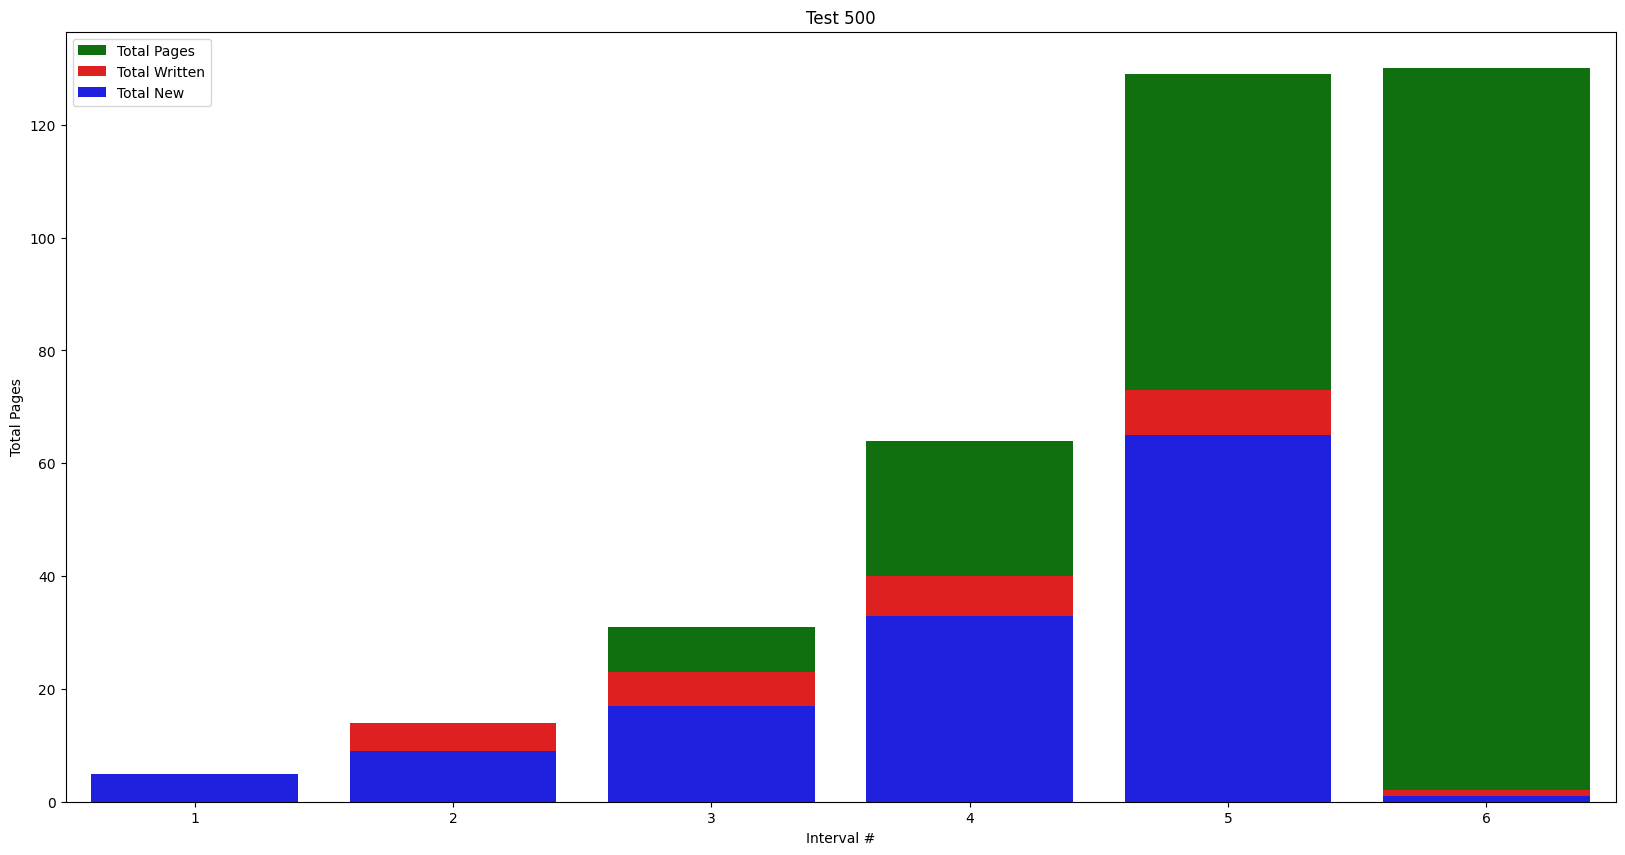

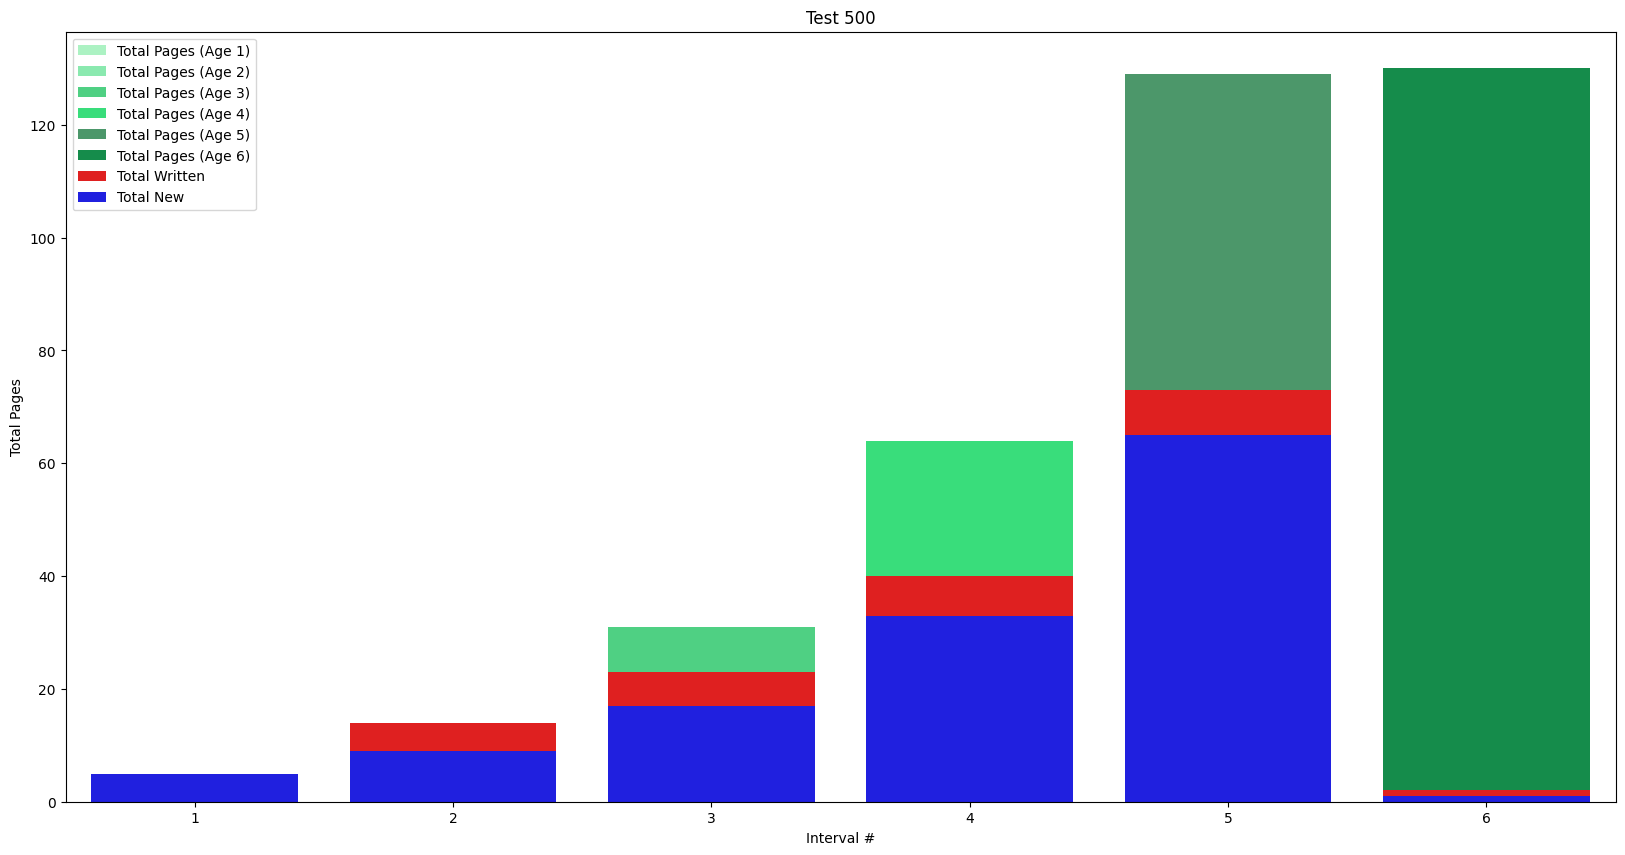

Done with second graph, moving on to the next...


<Figure size 2000x2000 with 0 Axes>

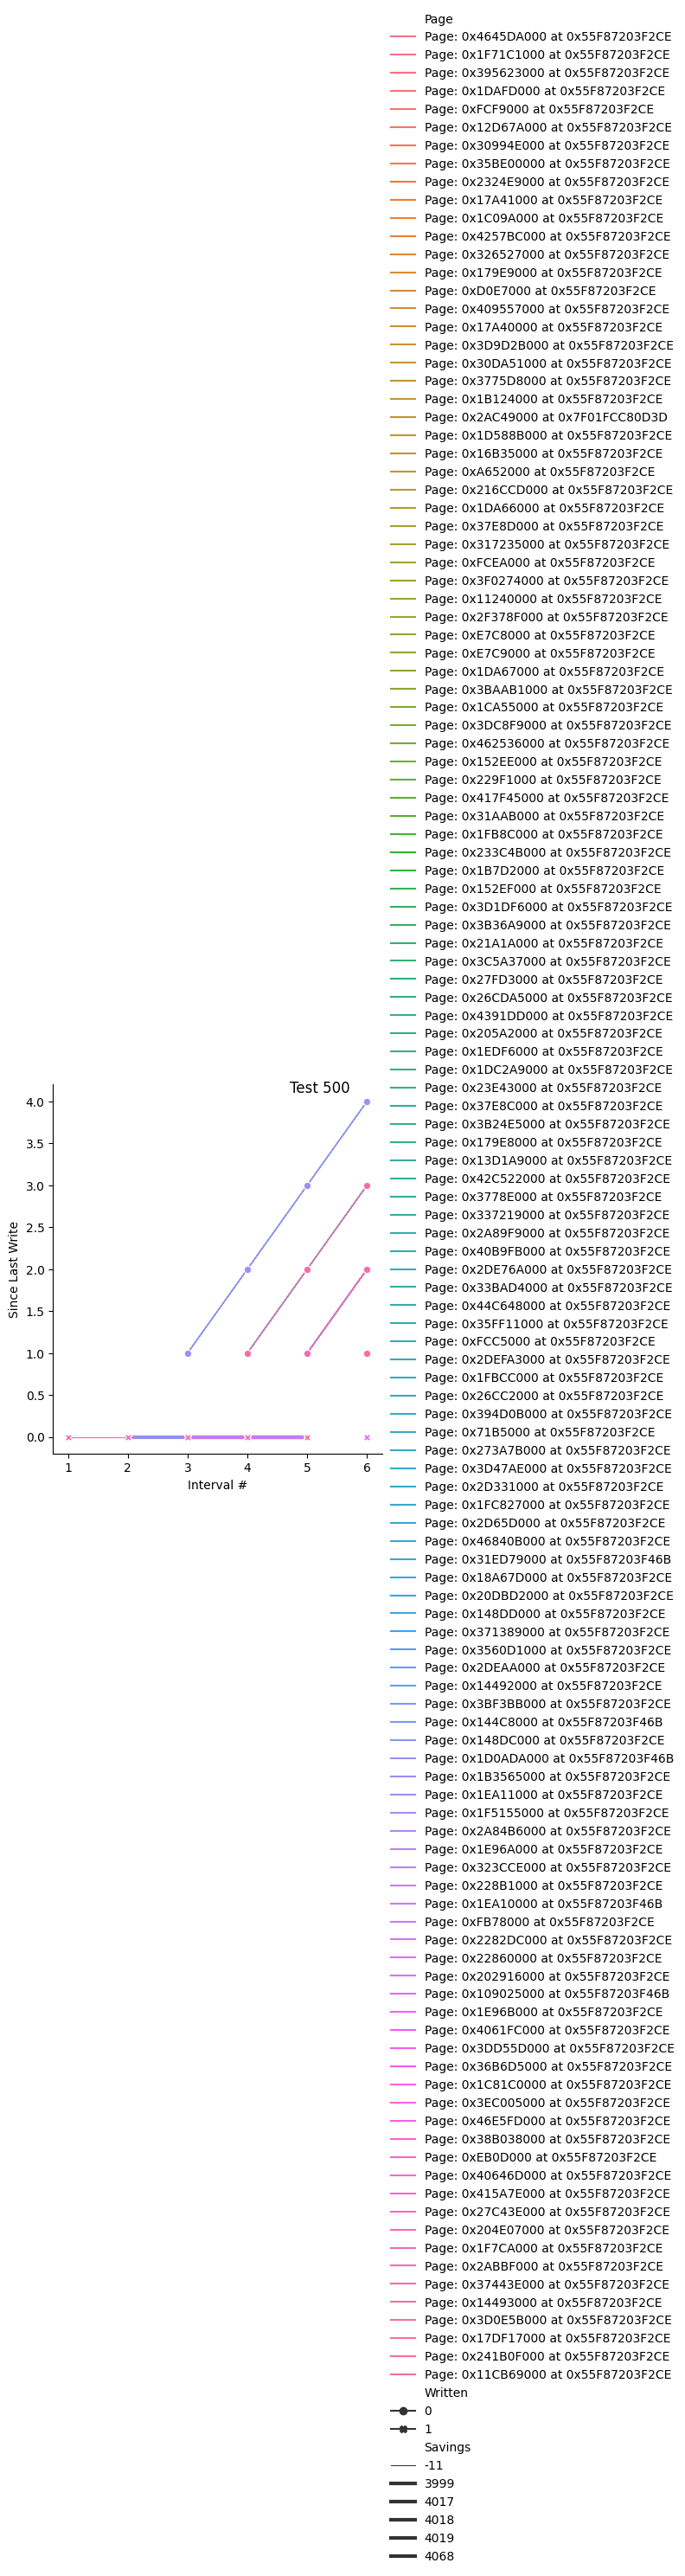

Done with third graph, moving on to the next...


<Figure size 2000x2000 with 0 Axes>

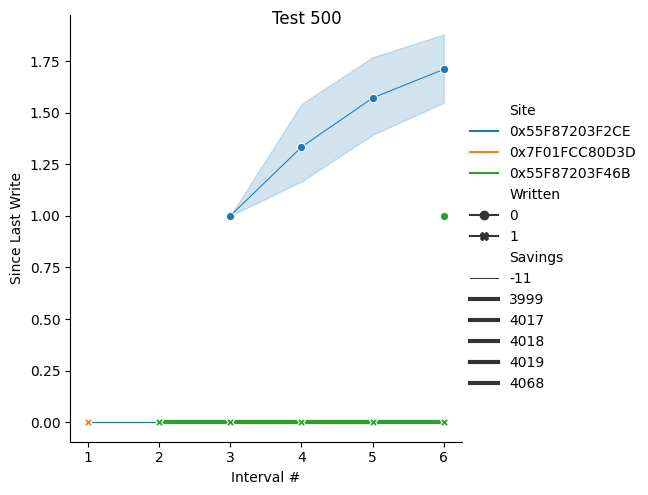

Done with fourth graph, moving on to the next...


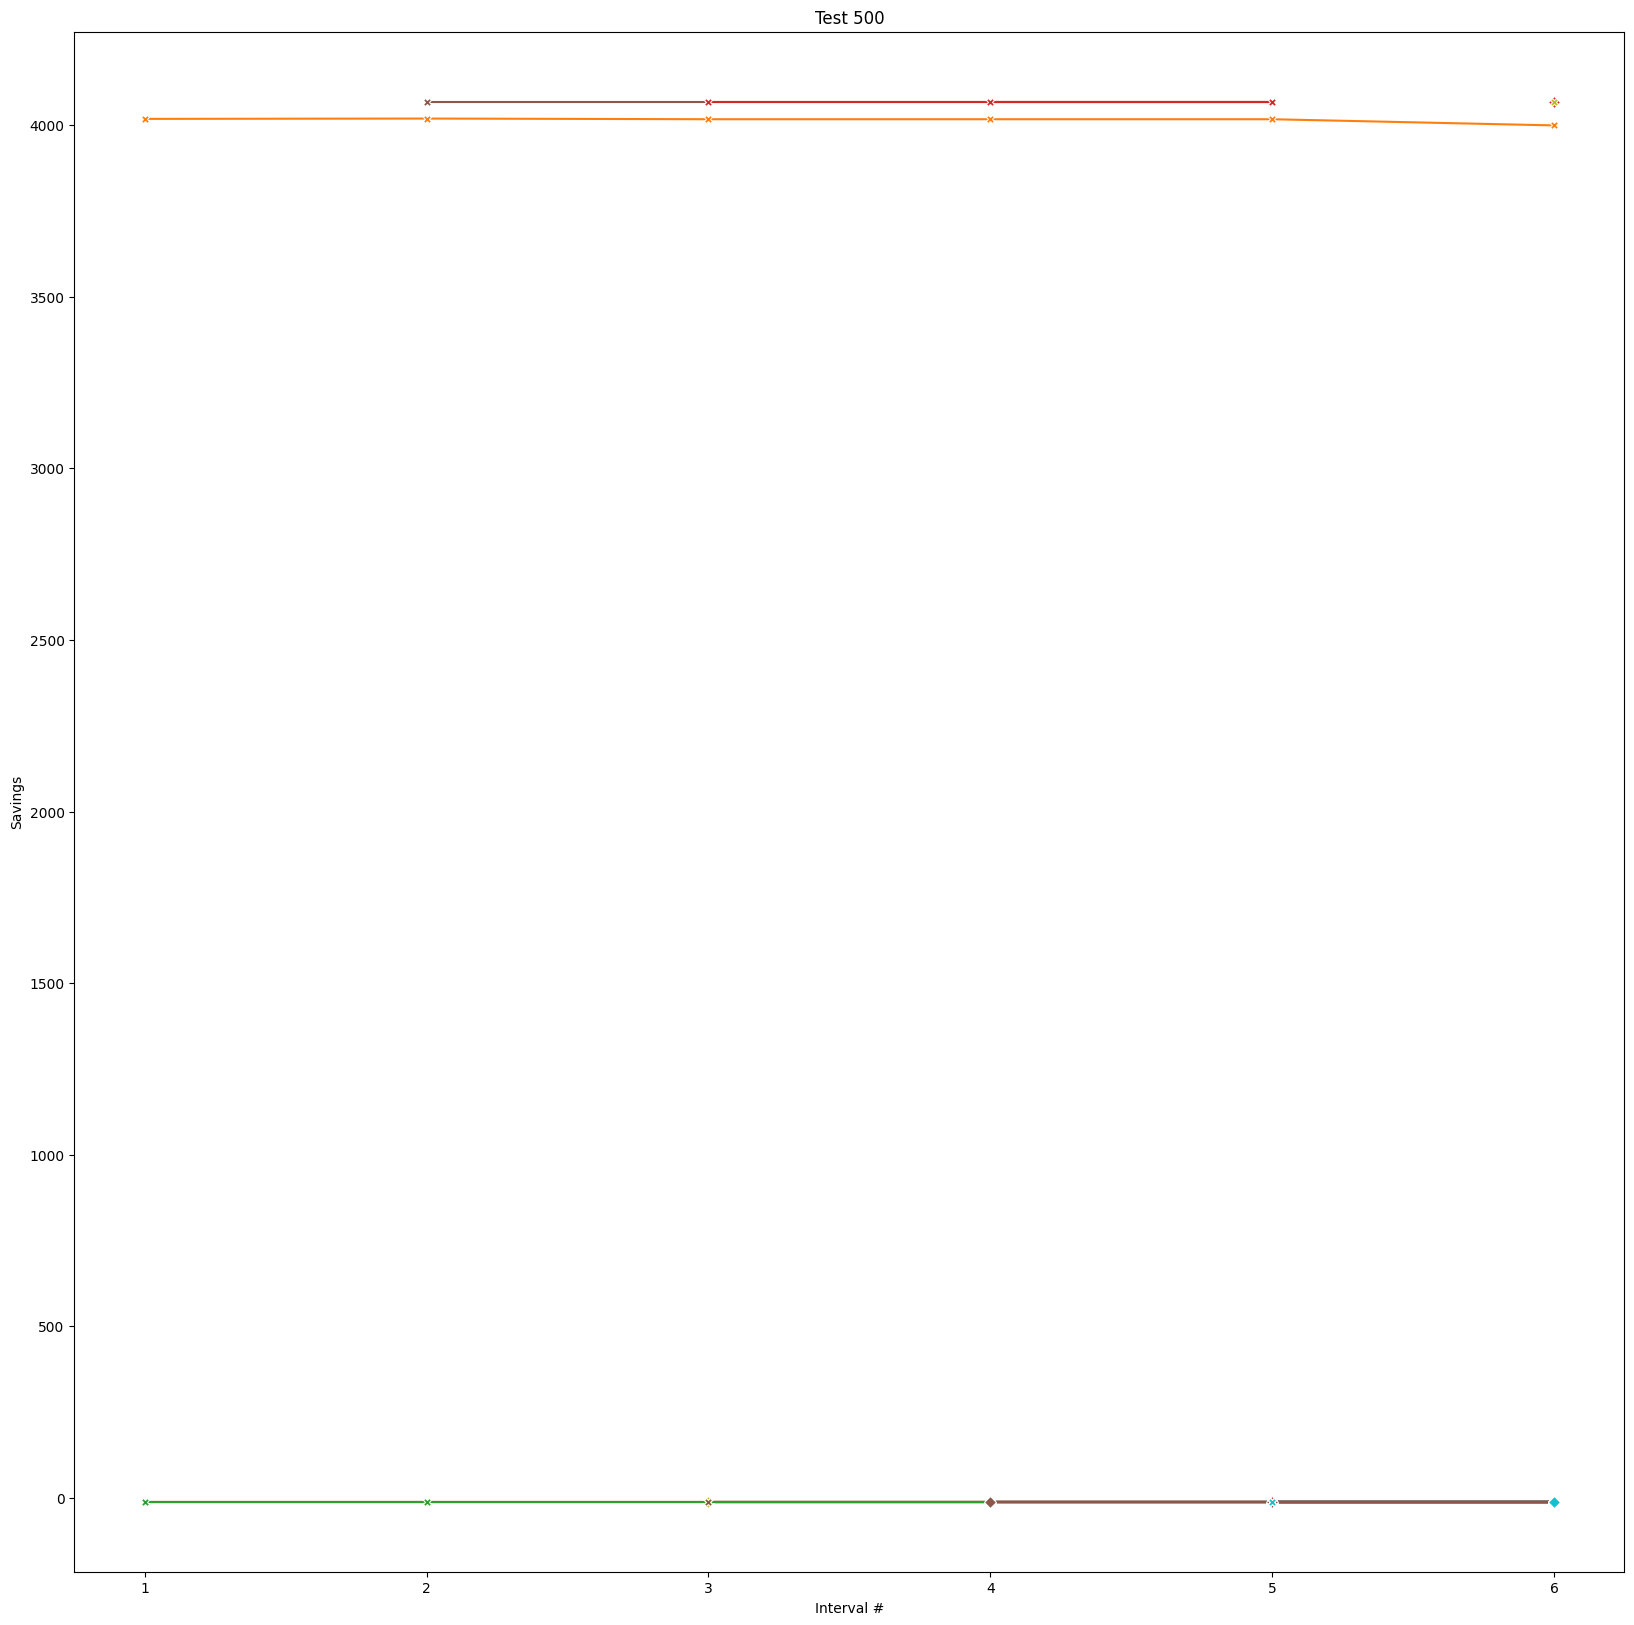

Done with fifth graph, moving on to the next...


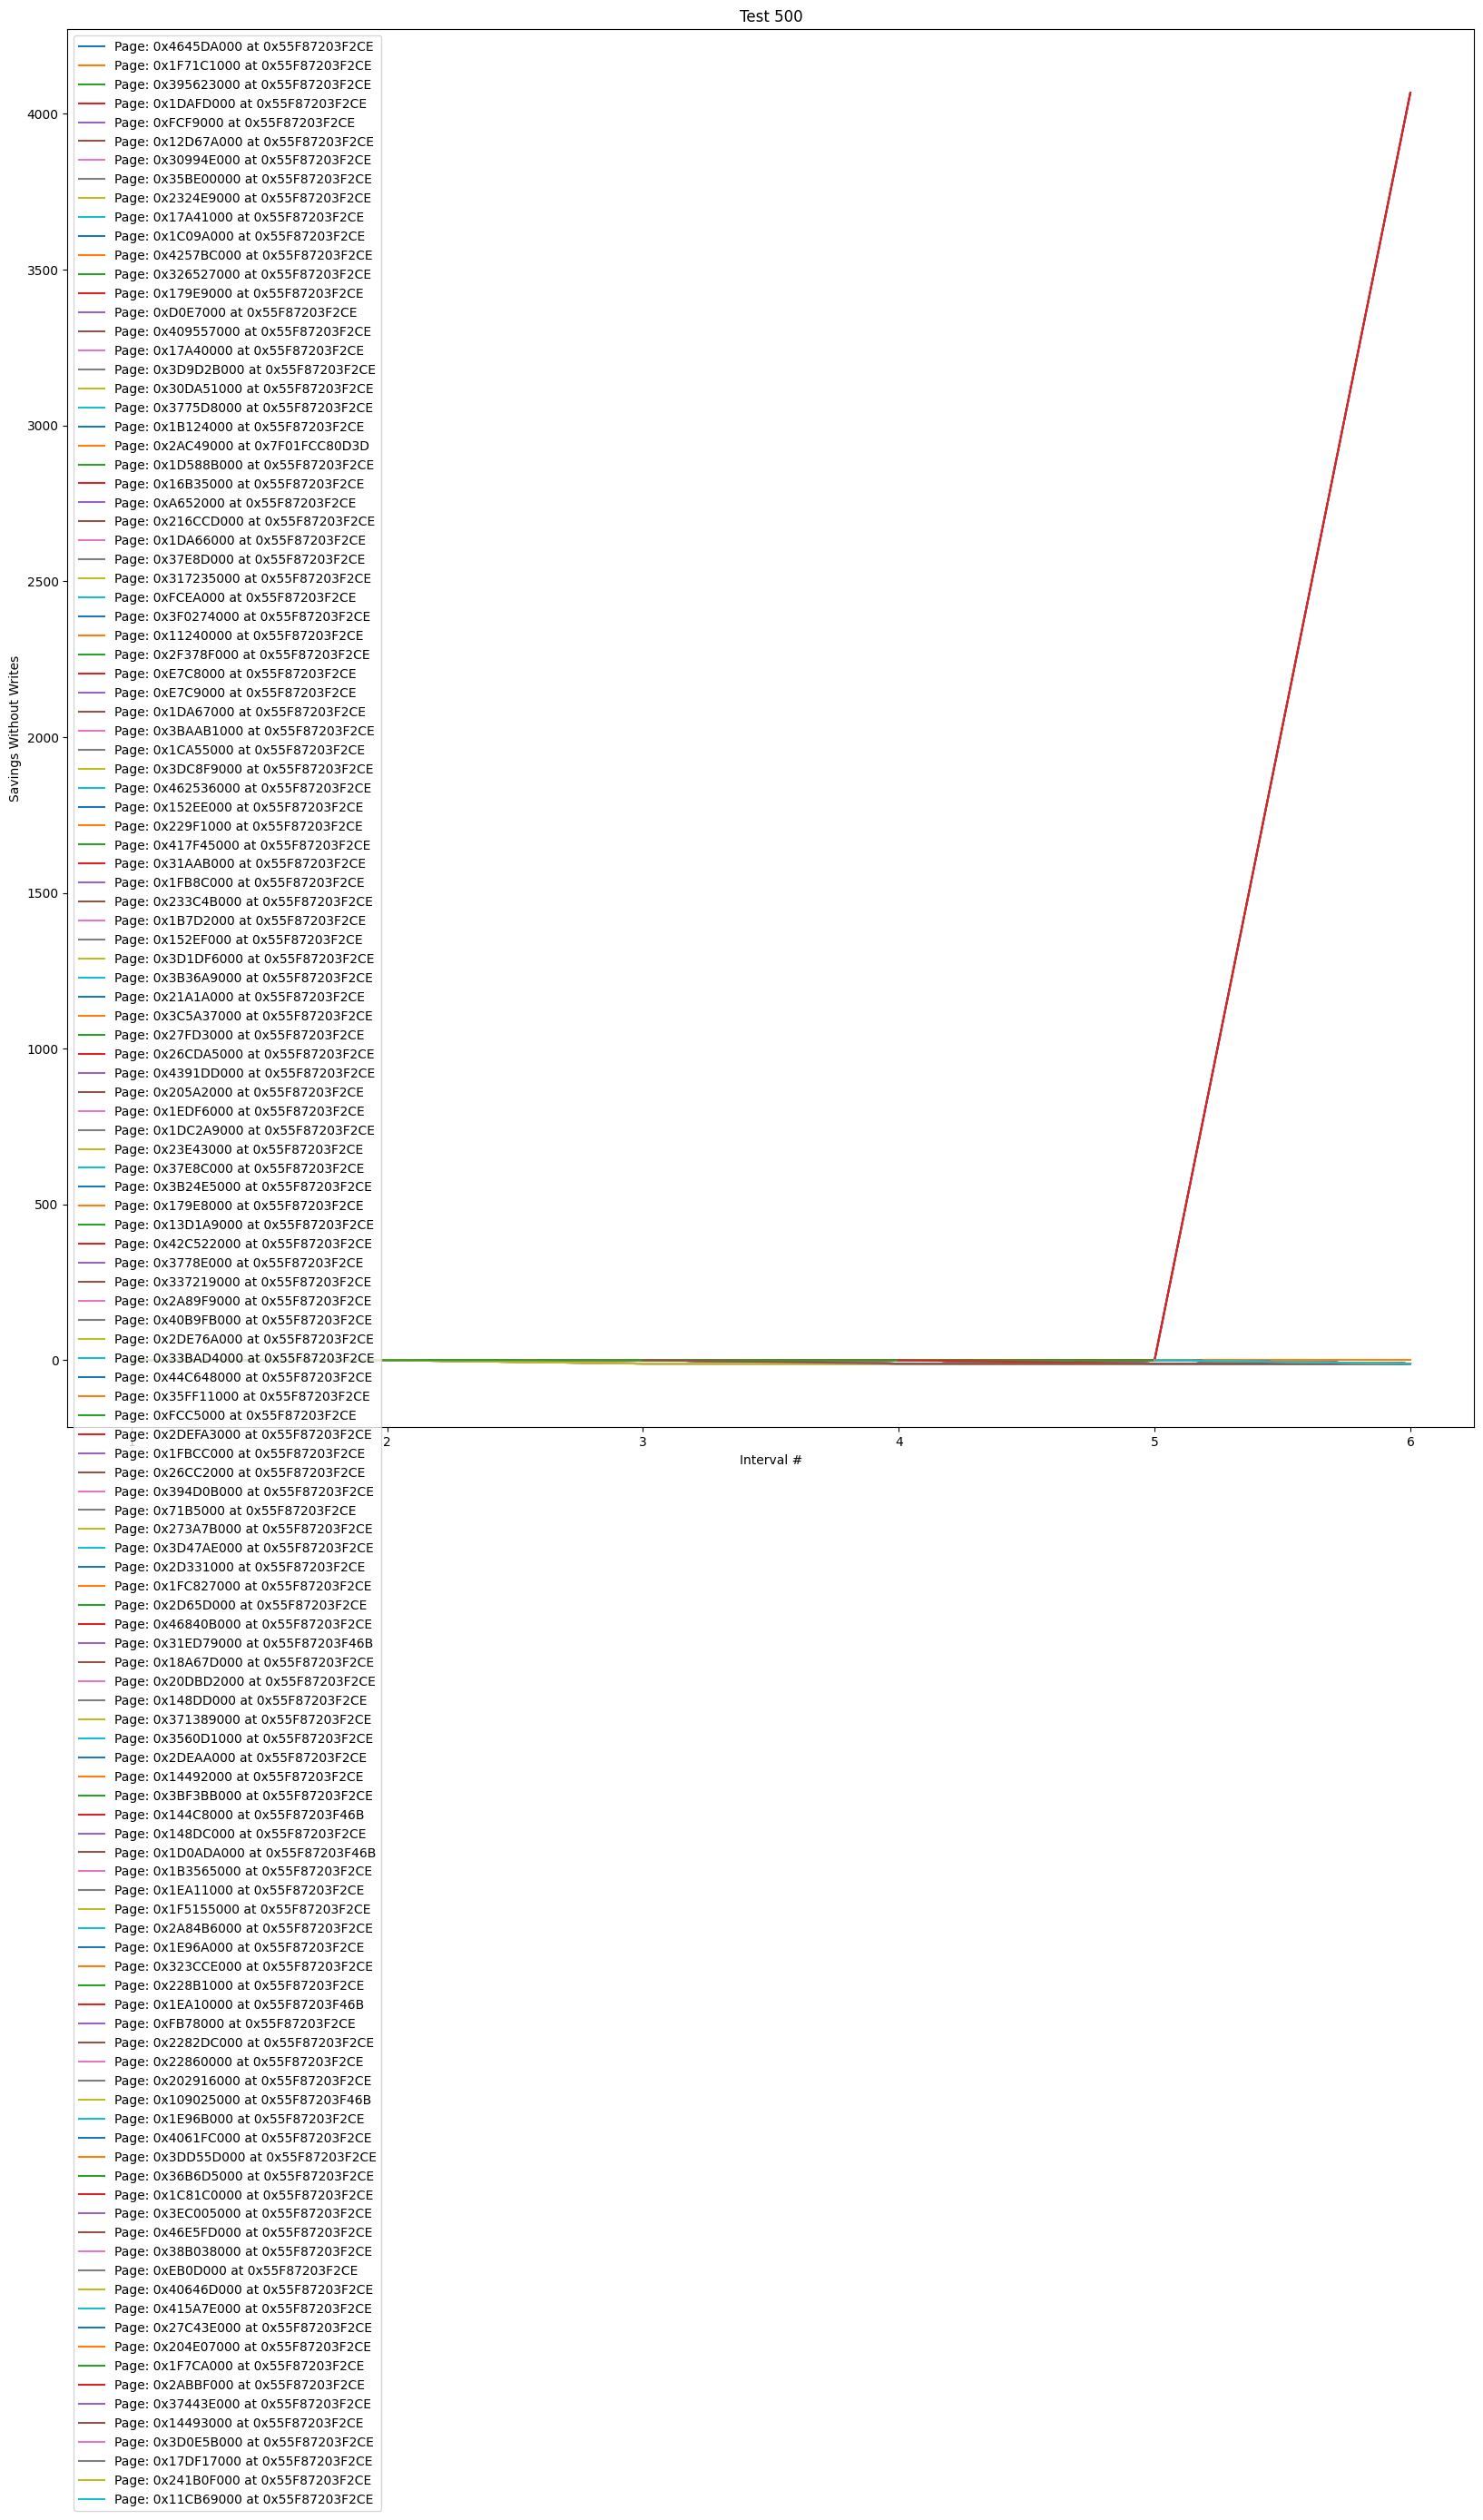

In [5]:
# Now that we have the data, we can graph it
# For each test, we want to graph the following (with the interval # as the x-axis):
#   - The total number of objects (as the y-axis) subdivided into the following categories:
#      - Total number of objects
#      - New objects that interval
#      - Objects that were written to that interval
#
# The graph should be a stacked bar graph, with a segment for each object colored by the category it falls into
# The brightness of each segment should be proportional to the amount of memory saved by compressing the physical pages
# Draw a line through the segments corresponding to each object to show how long the object lived for

for test_number, page_data in test_page_data.items():
    try:
        # Get the data for each object
        print("Test " + str(test_number))
        result_data = pd.DataFrame()
        pages = set(page_data.values())

        if len(page_data) == 0:
            print("No pages to process for test " + str(test_number))
            continue

        min_interval = int(all_data[test_number]["Interval #"].min())
        max_interval = int(all_data[test_number]["Interval #"].max())

        total_pages = [
            sum([1 for p in pages if p.get_first_interval() <= i and p.get_last_interval() >= i]) for i in range(min_interval, max_interval + 1)
        ]
        total_written = [
            sum([1 for p in pages if p.was_written_to_during_interval(i)]) for i in range(min_interval, max_interval + 1)
        ]
        total_new = [
            sum([1 for p in pages if p.get_first_interval() == i]) for i in range(min_interval, max_interval + 1)
        ]

        print("Total pages for intervals: " + str(total_pages))
        print("Total written for intervals: " + str(total_written))
        print("Total new for intervals: " + str(total_new))

        # Just do the top 1000 sized objects
        print("Tracked " + str(len(pages)) + " pages")
        max_tracked = 250
        # pages = sorted(pages, key=lambda o: o.get_physical_size_in_bytes(), reverse=True)[:max_tracked]

        for i, p in enumerate(pages):
            percent_done = (int(i + 1) * 100 / len(pages))
            if percent_done % 10 == 0:
                print(str(percent_done) + "% done") 

            savings = [
                row["Compression Savings (bytes)"] for row in p.data
            ]
            savings_without_writes = [
                row["Compression Savings (bytes)"] if not row["Written During This Interval?"] else 0 for row in p.data
            ]
            since_last_write = [i - p.get_interval_of_last_write(i) for i in range(p.get_first_interval(), p.get_last_interval() + 1)]
            result_data = pd.concat([result_data, pd.DataFrame({
                "Interval #": [row["Interval #"] for row in p.data],
                "Total Pages": [total_pages[row["Interval #"] - min_interval] for row in p.data],
                "Total Written": [total_written[row["Interval #"] - min_interval] for row in p.data],
                "Total New": [total_new[row["Interval #"] - min_interval] for row in p.data],
                "Written": [int(row["Written During This Interval?"]) for row in p.data],
                "New": [int(row["Is new?"]) for row in p.data],
                "Percent Savings": [
                    # Zero if the object was written to, otherwise the amount of memory saved by compressing the physical pages
                    row["Compression Savings (bytes)"] if not row["Written During This Interval?"] else 0 for row in p.data
                ],
                "Savings": savings,
                "Savings Without Writes": savings_without_writes,
                "Since Last Write": since_last_write,
                "Age": [row["Age (intervals)"] for row in p.data],
                "Page": repr(p),
                "Site": p.get_site(),
            })])
        print("Done processing data for test " + str(test_number))
        print("Graphing data...")

        # Plot the data
        # sns.barplot(x="Interval #", y="Total Objects", data=object_data, color="green", legend="full")
        # sns.barplot(x="Interval #", y="Total Written", data=object_data, color="red", legend="full")
        # sns.barplot(x="Interval #", y="Total New", data=object_data, color="blue", legend="full")

        # Create a multibar plot
        plt.figure(figsize=(20,10))
        plt.title("Test " + str(test_number))
        total_pages = sns.barplot(x="Interval #", y="Total Pages", data=result_data, color="green", label="Total Pages")
        total_hot = sns.barplot(x="Interval #", y="Total Written", data=result_data, color="red", label="Total Written")
        total_new = sns.barplot(x="Interval #", y="Total New", data=result_data, color="blue", label="Total New")
        # plt.legend(handles=[total_obj, total_hot, total_new], labels=["Total Objects", "Total Written", "Total New"])
        print("Done with first graph, moving on to the next...")
        plt.show()

        # Show the same multibar plot, but with 16 shades of green for ages <= 16
        plt.figure(figsize=(20,10))
        plt.title("Test " + str(test_number))
        total_pages_age_1 = sns.barplot(x="Interval #", y="Total Pages", data=result_data[result_data["Age"] == 1], color=sns.xkcd_rgb["light seafoam"], label="Total Pages (Age 1)")
        total_pages_age_2 = sns.barplot(x="Interval #", y="Total Pages", data=result_data[result_data["Age"] == 2], color=sns.xkcd_rgb["seafoam green"], label="Total Pages (Age 2)")
        total_pages_age_3 = sns.barplot(x="Interval #", y="Total Pages", data=result_data[result_data["Age"] == 3], color=sns.xkcd_rgb["weird green"], label="Total Pages (Age 3)")
        total_pages_age_4 = sns.barplot(x="Interval #", y="Total Pages", data=result_data[result_data["Age"] == 4], color=sns.xkcd_rgb["spearmint"], label="Total Pages (Age 4)")
        total_pages_age_5 = sns.barplot(x="Interval #", y="Total Pages", data=result_data[result_data["Age"] == 5], color=sns.xkcd_rgb["greenish"], label="Total Pages (Age 5)")
        total_pages_age_6 = sns.barplot(x="Interval #", y="Total Pages", data=result_data[result_data["Age"] == 6], color=sns.xkcd_rgb["emerald"], label="Total Pages (Age 6)")
        total_pages_age_7 = sns.barplot(x="Interval #", y="Total Pages", data=result_data[result_data["Age"] == 7], color=sns.xkcd_rgb["kelley green"], label="Total Pages (Age 7)")
        total_pages_age_8 = sns.barplot(x="Interval #", y="Total Pages", data=result_data[result_data["Age"] >= 8], color=sns.xkcd_rgb["green"], label="Total Pages (Age >=8)")
        total_hot = sns.barplot(x="Interval #", y="Total Written", data=result_data, color="red", label="Total Written")
        total_new = sns.barplot(x="Interval #", y="Total New", data=result_data, color="blue", label="Total New")
        plt.show()


        # Show
        # sns.barplot(x="Interval #", y="Percent Savings", data=object_data, color="green", ax=ax)
        # sns.lineplot(x="Interval #", y="Written", data=object_data, ax=ax)
        plt.figure(figsize=(20,20))
        g = sns.relplot(
            data=result_data,
            x="Interval #", y="Since Last Write", kind="line", hue="Page", size="Savings", style="Written", markers=True, dashes=False
        )
        # Set the title
        g.fig.suptitle("Test " + str(test_number))
        # plt.legend()
        print("Done with second graph, moving on to the next...")
        plt.show()

        plt.figure(figsize=(20,20))
        g = sns.relplot(
            data=result_data,
            x="Interval #", y="Since Last Write", kind="line", hue="Site", size="Savings", style="Written", markers=True, dashes=False
        )
        g.fig.suptitle("Test " + str(test_number))
        # plt.legend()
        print("Done with third graph, moving on to the next...")
        plt.show()

        plt.figure(figsize=(20,20))
        plt.title("Test " + str(test_number))
        for p in pages:
            sns.lineplot(x="Interval #", y="Savings", data=result_data[result_data["Page"] == repr(p)], label=repr(p), style="Written", legend=False, markers={1: "X", 0: "D"}, dashes=False)
        print("Done with fourth graph, moving on to the next...")
        plt.show()

        plt.figure(figsize=(20,20))
        plt.title("Test " + str(test_number))
        for p in pages:
            sns.lineplot(x="Interval #", y="Savings Without Writes", data=result_data[result_data["Page"] == repr(p)], label=repr(p), markers=True, dashes=False)
        print("Done with fifth graph, moving on to the next...")
        plt.show()
    except Exception as e:
        print("Error processing test " + str(test_number) + ": " + str(e))
        continue